## Training

## Image Classification Training Pipeline

This notebook implements an end-to-end training pipeline for an image classification task. It includes the following steps:
1. **Configuration Management**: Define and manage configurations for training and callbacks.
2. **Callbacks Preparation**: Set up TensorBoard and model checkpoint callbacks.
3. **Data Preparation**: Load and preprocess training and validation datasets.
4. **Model Training**: Train the model using the prepared data and callbacks.
5. **Model Saving**: Save the trained model for future use.

The pipeline is modular, making it easy to modify configurations, add new features, or reuse components for similar tasks.

In [1]:
import os

In [2]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list
    scan_over_freeze_till_models_path: Path  # <-- Add this line


@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [6]:
from ImageClassification.constants import *
from ImageClassification.utils import read_yaml, create_directories
import tensorflow as tf
tf.config.run_functions_eagerly(True)

2025-09-07 02:04:42.710379: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-07 02:04:42.710818: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 02:04:42.776614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 02:04:44.427859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [7]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "PetImages")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE,
            scan_over_freeze_till_models_path=Path(training.scan_over_freeze_till_models_path)
        )

        return training_config

In [8]:
import time

In [9]:
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    


    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),  # Convert WindowsPath to string
            save_best_only=True
        )


    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [10]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time

In [11]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path, compile=False
        )
        
        self.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )
        return history

## Learning Curves: Accuracy and Loss vs. Epochs

In the next cell, we will plot the learning curves for the training process, showing how the model's accuracy and loss evolve over the epochs for both the training and validation datasets.

### Accuracy
Accuracy is a metric that measures the proportion of correctly classified samples out of the total samples. It is calculated as:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

A higher accuracy indicates better model performance. The training accuracy shows how well the model performs on the training data, while the validation accuracy indicates its performance on unseen data.

### Loss
Loss is a measure of the error in the model's predictions. In this project, we use **categorical cross-entropy** as the loss function, which is commonly used for multi-class classification tasks.

Categorical cross-entropy measures the difference between the true label distribution (one-hot encoded) and the predicted probability distribution from the model. It is calculated as:

$$
\text{Loss} = -\sum_{i=1}^{C} y_i \log(p_i)
$$

where:
- $ y_i $ is the true label for class \( i \) (1 for the correct class, 0 for others)
- $ p_i $ is the predicted probability for class \( i \)
- $ C $ is the number of classes

Lower loss values indicate better model performance. Similar to accuracy, we track both training loss and validation loss.

### Interpreting the Graphs
1. **Training Curves**: The training accuracy and loss curves show how well the model is learning from the training data. Ideally, the training accuracy should increase, and the training loss should decrease over epochs.
2. **Validation Curves**: The validation accuracy and loss curves indicate how well the model generalizes to unseen data. Ideally, the validation accuracy should increase, and the validation loss should decrease. If the validation loss starts increasing while the validation accuracy plateaus or decreases, it may indicate overfitting.

By analyzing these graphs, we can assess the model's learning behavior and identify potential issues such as underfitting or overfitting.

[2025-09-07 02:30:53,002: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-09-07 02:30:53,004: INFO: common: yaml file: params.yaml loaded successfully]
[2025-09-07 02:30:53,005: INFO: common: created directory at: artifacts]
[2025-09-07 02:30:53,006: INFO: common: created directory at: artifacts/prepare_callbacks/checkpoint_dir]
[2025-09-07 02:30:53,006: INFO: common: created directory at: artifacts/prepare_callbacks/tensorboard_log_dir]
[2025-09-07 02:30:53,008: INFO: common: created directory at: artifacts/training]
Found 78 images belonging to 2 classes.
Found 318 images belonging to 2 classes.


/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4747 - loss: 4.0780[2025-09-07 02:31:16,769: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5503 - loss: 2.0435 - val_accuracy: 0.7179 - val_loss: 0.6053
Epoch 2/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7271 - loss: 0.6168[2025-09-07 02:31:40,932: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7233 - loss: 0.5941 -

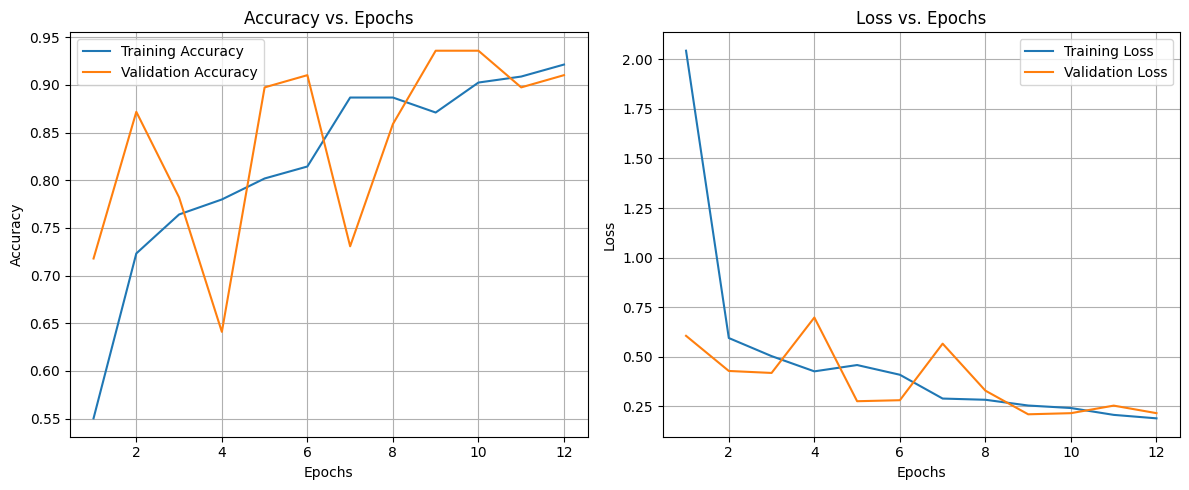

In [17]:
from plot_training_curve import plot_training_curves

try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    history = training.model.fit(
        training.train_generator,
        epochs=training.config.params_epochs,
        #steps_per_epoch=training.steps_per_epoch,
        #alidation_steps=training.validation_steps,
        validation_data=training.valid_generator,
        callbacks=callback_list
    )

    plot_training_curves(history)
    
except Exception as e:
    raise e

In [ ]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.train_valid_generator()

    # Loop over freeze_till values
    for freeze_till in range(0, 11):
        print(f"\nTraining with freeze_till={freeze_till}")
        # Load and update the base model for each freeze_till value
        training.get_base_model()  # Loads the base model
        # Freeze layers: you need to add this logic to your Training class or do it here
        for layer in training.model.layers[:-freeze_till] if freeze_till > 0 else []:
            layer.trainable = False
        for layer in training.model.layers[-freeze_till:] if freeze_till > 0 else training.model.layers:
            layer.trainable = True
        # Re-compile after changing trainable status
        training.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )
        # Train the model
        training.train(callback_list=callback_list)
        # Save with a unique name
        trained_model_path = str(training.config.scan_over_freeze_till_models_path).replace(".h5", f"_freeze_{freeze_till}.h5")
        training.save_model(trained_model_path, training.model)
        print(f"Saved model: {trained_model_path}")

except Exception as e:
    raise e

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Prepare to store results
freeze_till_values = []
val_accuracies = []
val_losses = []

# Loop through your saved models
for freeze_till in range(0, 11):
    model_path = str(training.config.scan_over_freeze_till_models_path).replace(".h5", f"_freeze_{freeze_till}.h5")
    print(f"Evaluating model: {model_path}")
    model = tf.keras.models.load_model(model_path)
    # Evaluate on validation data
    loss, acc = model.evaluate(training.valid_generator, verbose=0)
    freeze_till_values.append(freeze_till)
    val_accuracies.append(acc)
    val_losses.append(loss)
    print(f"freeze_till={freeze_till}: val_accuracy={acc:.4f}")

# Plot accuracy vs Freeze_till
plt.figure(figsize=(8, 5))
plt.plot(freeze_till_values, val_accuracies, marker='o')
plt.xlabel('freeze_till')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. No. of Re-trained Layers')
plt.grid(True)
plt.show()

# Plot loss vs Freeze_till
plt.figure(figsize=(8, 5))
plt.plot(freeze_till_values, val_losses, marker='o')
plt.xlabel('freeze_till')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. No. of Re-trained Layers')
plt.grid(True)
plt.show()

In [ ]:
# plot ROC curve
from plot_roc_curve import plot_roc_curve

